In [2]:
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
import pathlib
import os
os.environ['VXM_BACKEND'] = 'pytorch'
from voxelmorph import networks
import nibabel as nib
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as nnf


In [3]:
[*(pathlib.Path('/data01/junyi/results/tracts_related/seg9').iterdir())]
backbone_tracts = ['AF', 'ATR', 'CA', 'CC',
                   'CG', 'CST', 'FPT', 'ICP', 'IFO', 'ILF', 'MCP', 'MLF', 'OR', 'POPT', 'SCP','WGC']


In [4]:
from voxelmorph.py import utils

In [5]:
mask = [nib.load(path).get_fdata() for path in pathlib.Path('/data01/junyi/results/tracts_related/segsnapshot20_16tracts').glob(f'**/AF*.nii.gz')]


In [6]:
def quick_polar(A:torch.Tensor):
    temp_diag = []
    temp_diag.append(torch.stack([A[...,0,0]+A[...,1,1]+A[...,2,2],A[...,0,0]-A[...,1,1]-A[...,2,2],-A[...,0,0]+A[...,1,1]-A[...,2,2],-A[...,0,0]-A[...,1,1]+A[...,2,2]],-1)*0.5)
    temp_diag.append(torch.stack([A[...,1,2]-A[...,2,1],A[...,0,1]+A[...,1,0],A[...,1,2]+A[...,2,1]],-1)*0.5)
    temp_diag.append(torch.stack([A[...,2,0]-A[...,0,2],A[...,2,0]+A[...,0,2]],-1)*0.5)
    temp_diag.append(torch.stack([A[...,0,1]-A[...,1,0]],-1)*0.5)
    tempB = 0
    for i in range(4):
        tempB+=torch.diag_embed(temp_diag[i],-i)
        tempB+=torch.diag_embed(temp_diag[i],i)
    del temp_diag
    lamb = compute_lambda1(tempB.det(),A.det())
    tempBs = lamb.unsqueeze(-1).unsqueeze(-1)*torch.eye(4).reshape(*[1 for _ in range(lamb.ndim)],4,4).repeat(*(lamb.shape),1,1)-tempB
    return tempBs.shape
def compute_lambda1(b=0,d=0, eps=1e-4):
    mask = b+1/3 > eps
    lambda1 = torch.ones_like(b)
    # analytic
    c=8*d
    delta0 = 1+3*b[mask]
    delta1 = -1 +(27/16)*c[mask]**2 + 9*b[mask]
    alpha = delta1/(delta0)**1.5
    z = 4/3*(1+ delta0**0.5*torch.cos(torch.arccos(alpha)/3))
    s = 0.5*z**0.5
    lambda1[mask] = s + 0.5*torch.relu(4-z+c[mask]/s)**0.5
    lambda1[~mask] = newton_method(b[~mask],c[~mask])
    return lambda1.reshape(mask.shape)
def newton_method(b,c):
    x = 3**0.5*torch.ones_like(b)
    x_old = 3*torch.ones_like(b)
    px = torch.zeros_like(b)
    dpx = torch.zeros_like(b)
    mask = x_old-x > 1e-12
    while mask.all():
        x_old[mask] = x[mask]
        px[mask] = x[mask]*(x[mask]*(x[mask]**2 - 2)-c)+b[mask]
        dpx[mask] = 1/(x[mask]*(4*x[mask]**2-4)-c[mask])
        x[mask] = x[mask]-px[mask]*dpx[mask]
        mask = x_old-x > 1e-12
    return x
    # torch.diag_embed()

In [120]:
def fast_polar(A:torch.Tensor):
    temp = A
    device = A.device
    temp_norm = torch.ones((*(A.shape[:-2]),1,1),device=device)
    mask = torch.ones(A.shape[:-2],dtype=bool,device=device)
    old_norm = torch.ones((*(A.shape[:-2]),1,1),device=device)
    tempinv = torch.ones((*(A.shape[:-2]),3,3),device=device)
    tempinv_norminv = torch.ones(A.shape,device=device)
    # gamma = torch.ones(A.shape,device=device)
    for _ in range(100):
        old_norm[mask] = temp_norm[mask]
        temp_norm[mask] = torch.linalg.matrix_norm(temp[mask],dim=(-2,-1),keepdim=True)
        tempinv[mask] = torch.inverse(temp[mask])
        tempinv_norminv[mask] = torch.linalg.matrix_norm(tempinv[mask],dim=(-2,-1),keepdim=True)
        # gamma[mask] = torch.sqrt(temp_norm[mask] * 1/tempinv_norminv[mask])
        # temp[mask] = 0.5*(gamma[mask]*temp[mask] + 1/gamma[mask]*tempinv[mask].mT)
        temp[mask] = 0.5*(temp[mask] + tempinv[mask].mT)
        mask = (torch.abs(temp_norm-old_norm)>1e-5).squeeze()
        if (~mask).all():
            break
    return temp
def svd_polar(A:torch.Tensor):
    U,_,V=torch.svd(A)
    return torch.matmul(U,V.mT)

In [122]:
A = torch.rand(196*196*196,3,3,device='cuda:2')
M = fast_polar(A)

In [130]:
N = svd_polar(A)

In [138]:
M@M.mT

tensor([[[ 1.0000e+00,  3.7253e-09,  0.0000e+00],
         [ 3.7253e-09,  1.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 1.0000e+00,  0.0000e+00,  5.9605e-08],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
         [ 5.9605e-08,  0.0000e+00,  1.0000e+00]],

        [[ 1.0000e+00, -2.9802e-08,  0.0000e+00],
         [-2.9802e-08,  1.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        ...,

        [[ 1.0000e+00, -1.4901e-08,  2.9802e-08],
         [-1.4901e-08,  1.0000e+00,  2.9802e-08],
         [ 2.9802e-08,  2.9802e-08,  1.0000e+00]],

        [[ 1.0000e+00,  0.0000e+00,  4.4703e-08],
         [ 0.0000e+00,  1.0000e+00, -2.9802e-08],
         [ 4.4703e-08, -2.9802e-08,  1.0000e+00]],

        [[ 1.0000e+00,  5.9605e-08,  5.5879e-09],
         [ 5.9605e-08,  1.0000e+00,  3.7253e-09],
         [ 5.5879e-09,  3.7253e-09,  1.0000e+00]]], device='cuda:2')

In [131]:
torch.sum(torch.abs(M-N)<1e-5)/np.prod(M.shape)

tensor(0.0972, device='cuda:2')

In [137]:
torch.sum(torch.abs(M-N)<1e-3)/(196*196*196*3*3)

tensor(1.0000, device='cuda:2')

In [13]:

for tract in backbone_tracts:
    dice_lst = []
    mask = [nib.load(path).get_fdata() for path in pathlib.Path('/data01/junyi/results/tracts_related/segsnapshot20_16tracts_0.5_whole').glob(f'**/{tract}*.nii.gz')]
    for i in range(10):
        for j in range(10):
            dice = utils.dice(mask[i],mask[j])[0] if i>j else 0
            dice_lst.append(dice)
    dice_dict1[tract] = np.stack(dice_lst).reshape(10,-1)

In [14]:
np.savez('dice_model16_new.npz',**dice_dict1)

In [9]:
from scipy.stats import kstest
from scipy.stats import f_oneway

def ks_test(dist1,dist2):
    st,p= kstest(dist1,dist2,N=20,)
    return p
    if p>0.05:
        return 'ns'
    else:
        if p>0.01:
            return '*' 
        else:
            return '**'
dice = {}
results = {}

dice['Ants']= [np.sum(value)/45 for i,value in np.load('dice_ants.npz',allow_pickle=True).items() if not i =='FX']

dice['without_TOMs']=[np.sum(value)/45 for i,value in np.load('dice_modelFA_new1.npz',allow_pickle=True).items()if not i =='FX']

dice['Proposed']= [np.sum(value)/45 for i,value in np.load('dice_model16_new.npz',allow_pickle=True).items()if not i =='FX']
results['Propsed vs without TOM'] = []
results['Propsed vs Ants'] = []
for i,tract in enumerate(backbone_tracts):
    data = np.load('dice_modelFA_new1.npz',allow_pickle=True)[tract]
    pair_dist1=data[np.tril_indices(10,k=-1)]
    data = np.load('dice_ants.npz',allow_pickle=True)[tract]
    pair_dist2=data[np.tril_indices(10,k=-1)]
    data = np.load('dice_model16_new.npz',allow_pickle=True)[tract]
    pair_dist3=data[np.tril_indices(10,k=-1)]
    results['Propsed vs without TOM'] += [ks_test(pair_dist3,pair_dist1)]
    results['Propsed vs Ants'] += [ks_test(pair_dist3,pair_dist2)]
    

In [116]:
a ={}
try:
    a['a'] 
except:
    a['a'] =[]
a['a']
    

[]

In [7]:
import pandas as pd
import seaborn as sns
dice = {}

dice['Ants']= [value[np.tril_indices(10,k=-1)] for i,value in np.load('dice_ants.npz',allow_pickle=True).items() if not i in ['FX',]]

dice['without_TOMs']=[value[np.tril_indices(10,k=-1)] for i,value in np.load('dice_modelFA_new1.npz',allow_pickle=True).items()if not i in ['FX',]]

dice['Proposed']= [value[np.tril_indices(10,k=-1)] for i,value in np.load('dice_model16_new.npz',allow_pickle=True).items()if not i in ['FX',]]



# print()
# dataframe = pd.DataFrame.from_dict(dice)
# dataframe

In [8]:
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats import multicomp
pvalues = []
iterables = [['Ants','without TOMs', 'Proposed'],backbone_tracts,range(45)]
index = pd.MultiIndex.from_product(iterables, names=['Methods','Tracts','SUB_ID'])
df = pd.DataFrame(np.stack([v for i, v in dice.items()]).reshape(-1),index=index).reset_index()
for tract in backbone_tracts:
    # print(df[df['Tracts']==tract].drop(columns='Tracts'))
    data = df[df['Tracts']==tract].drop(columns='Tracts')
    print(AnovaRM(data=data, depvar=0, 
              subject='SUB_ID', within=['Methods'], aggregate_func='mean').fit()) 
    mcresult = multicomp.MultiComparison(data[0],data['Methods'])
    result = mcresult.tukeyhsd()
    print(result)
    pvalues.append(result.pvalues)
    # if result.pvalues <0.05:
        
    # print(['n.s' for p in result.pvalues if p>0.05 ])
    # print(result.pvalues<0.05,result.meandiffs)
    # pairwise_tukeyhsd(data,groups=['Ants','without TOMs', 'Proposed'])
pr =pd.DataFrame(np.stack(pvalues),columns=['Propsed vs Ants','Ants vs without TOM','Propsed vs without TOM'])

                Anova
        F Value  Num DF  Den DF Pr > F
--------------------------------------
Methods 202.7040 2.0000 88.0000 0.0000

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1     group2    meandiff p-adj lower  upper  reject
---------------------------------------------------------
    Ants     Proposed   0.0384   0.0 0.0307 0.0461   True
    Ants without TOMs   0.0657   0.0  0.058 0.0735   True
Proposed without TOMs   0.0273   0.0 0.0196 0.0351   True
---------------------------------------------------------
                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
Methods 87.4405 2.0000 88.0000 0.0000

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1     group2    meandiff p-adj   lower  upper  reject
-----------------------------------------------------------
    Ants     Proposed   0.0449    0.0  0.0346 0.0552   True
    Ants without TOMs   0.0514    0.0  0.0411 0.0617   True
Proposed without 

In [10]:
def mark(pvalue):
    if pvalue>0.05:
        return 'ns'
    else:
        if pvalue>0.01:
            return '*' 
        else:
            return '**'
def bar_chart(group_num,score:dict,barWidth =0.6,anno=None):
    fig,ax = plt.subplots(figsize=(6,5))
    br1 = np.arange(group_num)*2 
    br2 = [x + barWidth+0.2 for x in br1] 
    br3 = [x + barWidth+0.2 for x in br2]
    plt.bar(br1,np.stack(score['Ants'])[-1]-0.5,width = barWidth, bottom=0.5, label= 'SyN')
    plt.bar(br2,np.stack(score['without_TOMs'])[-1]-0.5,width = barWidth, bottom=0.5,label= 'VoxelMorph')
    plt.bar(br3,np.stack(score['Proposed'])[-1]-0.5,width = barWidth, bottom=0.5,label= 'Proposed method')
    y = np.stack([v for k,v in score.items()]).max(0)
    if not anno is None:
        for  i,tract in enumerate(backbone_tracts[-1:]):
            h = 0.005
            y = np.stack([v for k,v in score.items()])[(0,2),:].max(0)-0.1
            plt.plot([br1[i],br1[i],br3[i],br3[i]],[y[i],y[i]+h,y[i]+h,y[i]], lw=1.5,c='k')
            # this_anno = f"{anno[tract+' Propsed vs Ants' ][-1] :.3f}" if not anno[tract+' Propsed vs Ants' ] ==None else 'ns'
            plt.text((br1[i]+br3[i])/2, y[i]+h, mark(anno['Propsed vs Ants' ][-1]), ha='center', va='bottom', color='k')
            # plt.text((br1[i]+br3[i])/2, y[i]+h, this_anno, ha='center', va='bottom', color='k')
            y = np.stack([v for k,v in score.items()])[(1,2),:].max(0)-0.1
            h = 0.01
            plt.plot([br2[i],br2[i],br3[i],br3[i]],[y[i],y[i]+h,y[i]+h,y[-i]], lw=1.5,c='k')
            # this_anno = f"{anno[tract+' Propsed vs without TOM'][-1] :.3f}" if not anno[tract+' Propsed vs without TOM']==None else 'ns'
            plt.text((br2[i]+br3[i])/2, y[i]+h, mark(anno[ 'Propsed vs without TOM'][-1]), ha='center', va='bottom', color='k')
            # plt.text((br2[i]+br3[i])/2, y[i]+h, this_anno, ha='center', va='bottom', color='k')
    # plt.xlabel('Gray Matter White Matter and CSF', fontweight ='bold', fontsize = 15) 
    plt.ylabel('Segmentation of GM, WM and CSF', fontweight ='bold', fontsize = 8) 
    # plt.xticks([r + barWidth +0.2 for r in br1], 
    #         ['Gray Matter White Matter and CSF'])
    plt.xticks([br1[0],br2[0],br3[0]],['SyN','VoxelMorph','Proposed method'])
    # plt.legend(loc ='upper right', bbox_to_anchor=(1.0, 0.25))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.savefig('all.png',bbox_inches='tight')


In [109]:
results['Propsed vs Ants']

array([], dtype=float64)

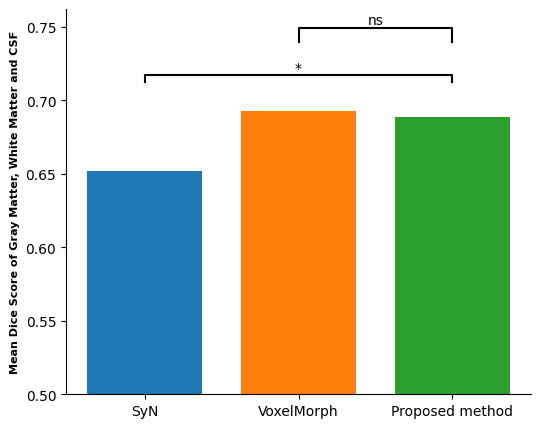

In [11]:
# bar_chart(16,dice,)
bar_chart(1,dice,anno=results)


In [11]:
dice_dict1 = np.load('dice_model16.npz',allow_pickle=True)
# dice_dict = np.load('dice_model.npz',allow_pickle=True)

Text(0.5, 0.9, 'Dice difference of  Purposed Method and Ants')

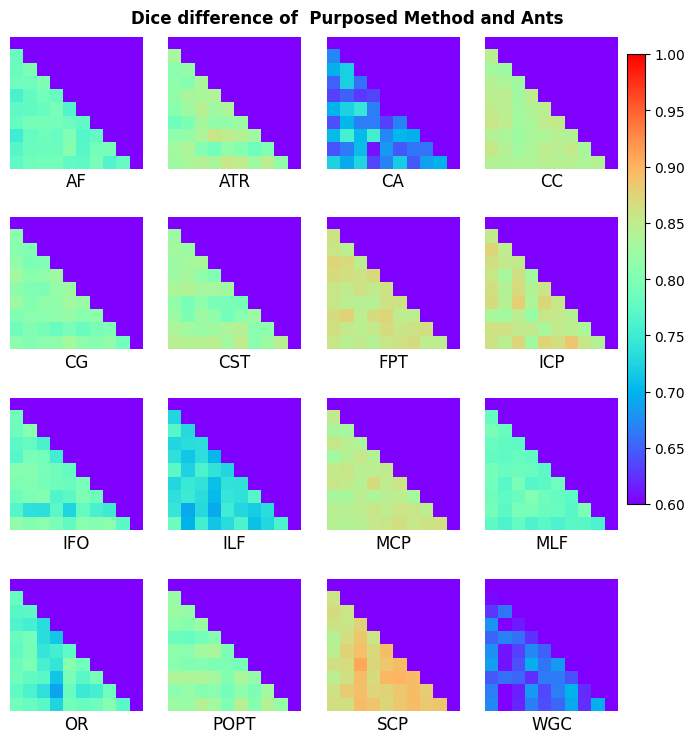

In [14]:
fig, axes = plt.subplots(4,4,figsize=(9,9))
# print(np.sum((dice_dict[tract]-dice_dict1[tract])<0))
axes = axes.flat

for i,tract in enumerate(backbone_tracts):
    im = axes[i].imshow((dice_dict1[tract]),vmin=.6,vmax=1,cmap='rainbow')
    axes[i].axis('off')
    axes[i].set_title(tract,y=-0.2)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81,0.35,0.02,0.5])
fig.colorbar(im,cbar_ax)
fig.suptitle('Dice difference of  Purposed Method and Ants',y=0.9,fontweight='bold')


tensor([[0.9940, 0.7810, 0.6202, 0.4559, 0.3109, 0.2173, 0.1497, 0.0966, 0.0527,
         0.0343],
        [0.7810, 0.9943, 0.8077, 0.6186, 0.4333, 0.3070, 0.2163, 0.1426, 0.0786,
         0.0500],
        [0.6202, 0.8077, 0.9946, 0.7811, 0.5763, 0.4147, 0.2917, 0.2017, 0.1190,
         0.0744],
        [0.4559, 0.6186, 0.7811, 0.9943, 0.7542, 0.5637, 0.4076, 0.2946, 0.1895,
         0.1210],
        [0.3109, 0.4333, 0.5763, 0.7542, 0.9938, 0.7573, 0.5777, 0.4407, 0.3070,
         0.2010],
        [0.2173, 0.3070, 0.4147, 0.5637, 0.7573, 0.9939, 0.7878, 0.6292, 0.4626,
         0.3132],
        [0.1497, 0.2163, 0.2917, 0.4076, 0.5777, 0.7878, 0.9944, 0.8079, 0.6195,
         0.4286],
        [0.0966, 0.1426, 0.2017, 0.2946, 0.4407, 0.6292, 0.8079, 0.9947, 0.7841,
         0.5765],
        [0.0527, 0.0786, 0.1190, 0.1895, 0.3070, 0.4626, 0.6195, 0.7841, 0.9944,
         0.7603],
        [0.0343, 0.0500, 0.0744, 0.1210, 0.2010, 0.3132, 0.4286, 0.5765, 0.7603,
         0.9938]], dtype=tor

In [12]:
def tract_distance(voxels,num_ind):
    tract_warped = voxels.reshape(num_ind,3,-1).permute(-1,0,1)
    mask = (torch.abs(tract_warped).max(-1,keepdim=True)[0] > 5e-2).float()
    overlap = ((mask @ mask.mT) > 1e-5).float()
    weight = overlap/overlap.sum(0,keepdim=True)

    top = torch.clip(tract_warped @ tract_warped.mT,min=1e-7)
    vec_len = torch.sqrt((tract_warped)**2)

    bottom = torch.clip(vec_len @ vec_len.mT,min=1e-7)

    return (top/bottom*weight).sum(0)

In [13]:
batch_size=10

In [34]:
dataset = TOMDatasetDir('../HCP_100')
data = DataLoader(dataset,batch_size=batch_size,shuffle=True)
eval_data = next(iter(data)).to('cuda:5')

with torch.no_grad():
    model.to('cuda:5').eval()
    outputs = model(eval_data)

In [33]:
tract_shape_dice(torch.stack((outputs[1][5,...],eval_data[5])),2)

tensor([[1.0000, 0.5979],
        [0.5979, 0.9999]], device='cuda:5')

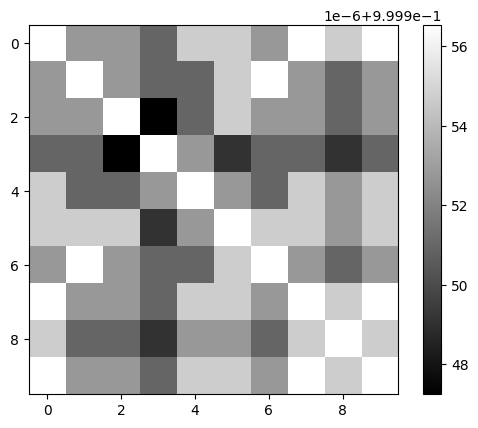

In [35]:
SM = tract_shape_dice(outputs[0],batch_size)
# print(SM)
SM1 = tract_shape_dice(eval_data,batch_size)
# print(SM-SM1)
plt.imshow((SM).cpu(),cmap='gray')
plt.colorbar()